# Aggregating Split Attributes

This short tutorial shows how to summarise metrics calculated on split geometries into a raster grid and write the result to disk.

In [1]:
from pathlib import Path

import pandas
from snail.intersection import GridDefinition, aggregate_values_to_grid
from snail.io import write_grid_to_raster

In [2]:
dir = Path().resolve().parent.parent
data_folder = dir / "ghana_tutorial"
# data_folder = Path("YOUR_PATH/ghana_tutorial")

In [3]:
! ls {data_folder}/results

direct_route.png
GHA_OSM_roads_edges___exposure.geoparquet
inunriver_damages_ead.csv
inunriver_damages_ead__historical.csv
inunriver_damages_rp.csv
inunriver_historical_000000000WATCH_1980_rp00100__roads_exposure.csv
inunriver_historical_000000000WATCH_1980_rp00100__roads_exposure.gpkg
road_length_m_per_cell.tif


In [4]:
splits = pandas.read_parquet(data_folder / "results" / "GHA_OSM_roads_edges___exposure.geoparquet")

In [5]:
splits.iloc[0, :11]

osm_id                                                 4790594
road_type                                             tertiary
name                                              Airport Road
id                                                     roade_0
from_id                                                roadn_0
to_id                                                  roadn_1
length_m                                             48.717294
geometry     b'\x01\x02\x00\x00\x00\x02\x00\x00\x00\xbb\x05...
split                                                        0
i_0                                                        370
j_0                                                        667
Name: 0, dtype: object

In [6]:
hazard_paths = sorted((data_folder/ "flood_layer" / "gha" / "wri_aqueduct_version_2").glob("*.tif"))
hazard_paths[0].name

'wri_aqueduct-version_2-inuncoast_historical_wtsub_2030_rp0001_5-gha.tif'

In [7]:
grid = GridDefinition.from_raster(hazard_paths[0])
grid

GridDefinition(crs=CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), width=534, height=771, transform=(0.008333333333333333, 0.0, -3.26666666666668, 0.0, -0.008333333333333333, 11.166666666666671))

In [8]:
length_raster = aggregate_values_to_grid(
    splits,
    'length_m',
    grid,
    index_i="i_0",
    index_j="j_0"
)
length_raster

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(771, 534))

In [9]:
write_grid_to_raster(
    length_raster,
    data_folder / "results" / "road_length_m_per_cell.tif",
    grid.transform,
    grid.crs
)

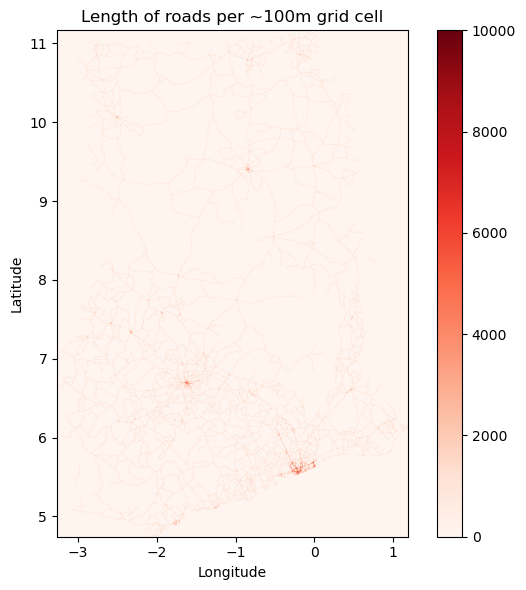

In [10]:
import rasterio

import matplotlib.pyplot as plt

tif_path = data_folder / "results" / "road_length_m_per_cell.tif"

with rasterio.open(tif_path) as agg:
    agg_arr = agg.read(1)
    agg_bounds = agg.bounds

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

im = ax.imshow(
    agg_arr,
    vmin=0,
    vmax=1e4,
    cmap="Reds",
    extent=(agg_bounds.left, agg_bounds.right, agg_bounds.bottom, agg_bounds.top),
    origin="upper",
)
ax.set_title("Length of roads per ~100m grid cell")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()